<a href="https://colab.research.google.com/github/MatveyLebedev/Cache-to-db-decorator/blob/main/customer_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
df = pd.read_csv('/content/total_data.csv')
df = df.drop(columns='request_id')
df.head()

,age,spoke_with_agent,documents_send,documents_recieved,flag,delivery_pickup,session_duration,bounce_rate,sessions,visited_partners,step_1,step_2,step_3,user_type
0,45,0,0,0,0,not_stated,0.0,1.0,1,0,0,0,0,new
1,45,0,0,0,0,delivery,171.0,0.0,1,0,1,0,0,old
2,31,1,0,0,0,pickup,40.0,0.0,1,0,0,0,0,new
3,23,1,0,0,0,pickup,229.0,0.0,2,1,2,0,0,new
4,29,1,0,0,0,pickup,152.0,0.0,1,1,0,0,0,old


In [ ]:
df.groupby('delivery_pickup').sum()

,age,spoke_with_agent,documents_send,documents_recieved,flag,session_duration,bounce_rate,sessions,visited_partners,step_1,step_2,step_3
delivery_pickup,,,,,,,,,,,,
delivery,83779,1016,394,184,192,1.073824e+06,11.583333,2819,25,2819,477,315
not_stated,37494,768,271,139,139,9.745523e+04,646.724459,1551,98,0,5,54
pickup,156059,3710,1131,357,354,1.050078e+06,63.366667,5919,120,4308,70,1640


In [ ]:
df.groupby('flag').sum()

,age,spoke_with_agent,documents_send,documents_recieved,session_duration,bounce_rate,sessions,visited_partners,step_1,step_2,step_3
flag,,,,,,,,,,,
0,251662,4927,1144,52,1.984653e+06,629.953030,9409,213,6530,421,1766
1,25670,567,652,628,2.367043e+05,91.721429,880,30,597,131,243


In [ ]:
def encode1(l):
    r = 0
    if l == 'not_stated': r = 0
    if l == 'delivery': r = 1
    if l == 'pickup': r = 2
    return r

def encode2(l):
    r = 0
    if l == 'new': r = 0
    if l == 'old': r = 1
    return r

df['delivery_pickup'] = df['delivery_pickup'].apply(encode1)
df['user_type'] = df['user_type'].apply(encode2)


In [ ]:
idf = df.copy()

# Балансируем
g = df.groupby('flag')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
df = pd.DataFrame(g)
df.head()

# Перемешиваем
df = df.sample(frac=1)

In [ ]:
df.corr()['flag']

age                   0.273247
spoke_with_agent      0.230448
documents_send        0.821930
documents_recieved    0.912121
flag                  1.000000
delivery_pickup      -0.084903
session_duration      0.131741
bounce_rate           0.107894
sessions              0.035555
visited_partners      0.043236
step_1                0.029397
step_2                0.233076
step_3                0.131360
user_type             0.149286
Name: flag, dtype: float64


 age


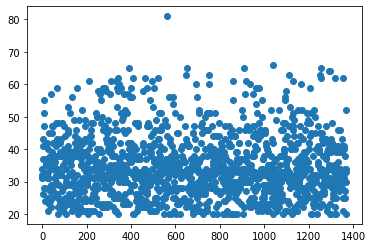


 spoke_with_agent


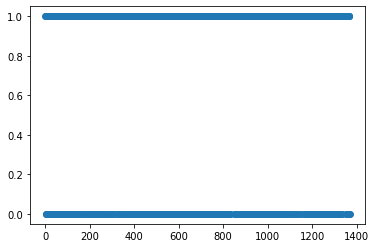


 documents_send


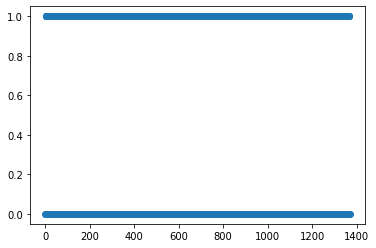


 documents_recieved


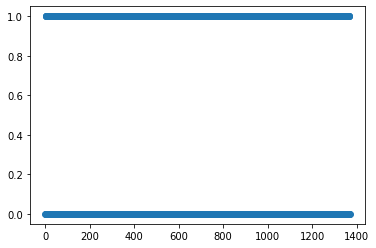


 flag


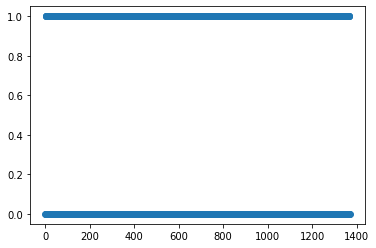


 delivery_pickup


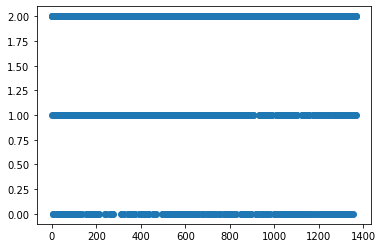


 session_duration


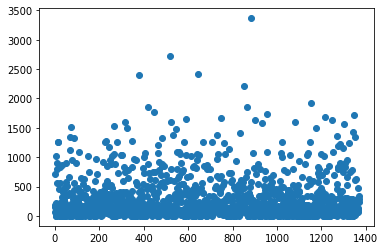


 bounce_rate


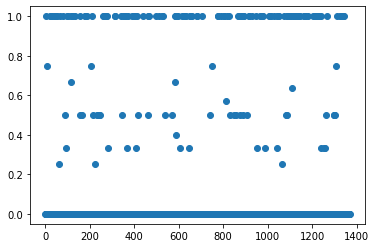


 sessions


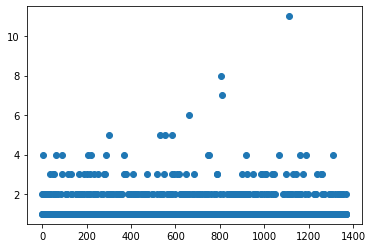


 visited_partners


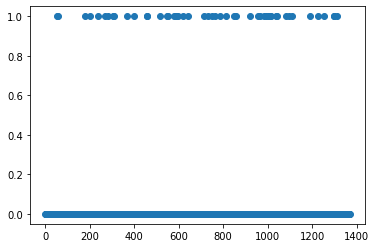


 step_1


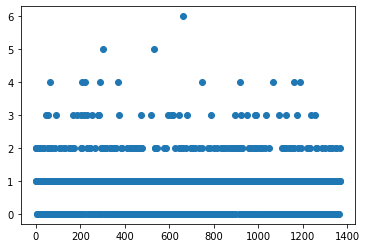


 step_2


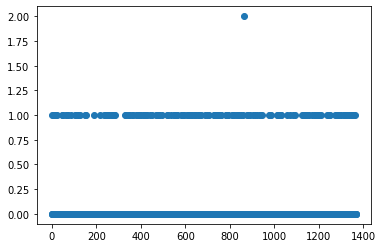


 step_3


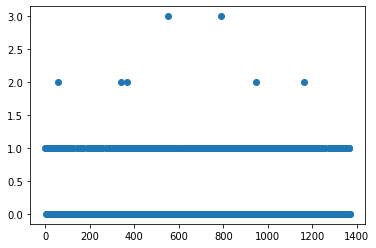


 user_type


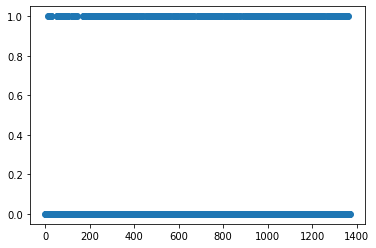

In [ ]:
for c in df.columns:
    plt.scatter(range(len(df[c])), df[c])
    print('\n', c)
    plt.pause(0.1)

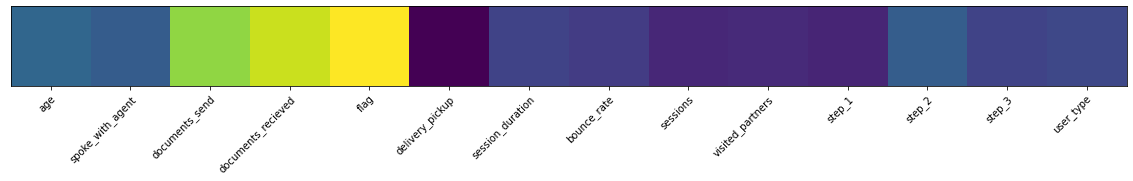

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.imshow([df.corr()['flag']])
ax.set_xticks(range(len(df.corr()['flag'].index)))
ax.set_xticklabels(df.corr()['flag'].index)
ax.set_yticks([])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
print('')

In [ ]:
df['age'] = df['age'] / 40

In [ ]:
df = df.drop(columns=['step_1', 'delivery_pickup', 'visited_partners', 'bounce_rate', 'step_3',
                      'session_duration', 'user_type', 'sessions'])

In [ ]:
df.head()

age  spoke_with_agent  ...  flag  step_2
flag                               ...              
0    622  0.775                 1  ...     0       0
1    344  0.850                 1  ...     1       0
     117  0.800                 1  ...     1       1
     521  1.075                 0  ...     1       0
0    313  0.925                 0  ...     0       0

[5 rows x 6 columns]

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
c_inv = df['flag'].replace({0: 1, 1: 0})

df_x = df.drop(columns='flag')
df_x = pd.get_dummies(df_x, columns=['step_2'])
df_y = pd.DataFrame({'Y': df['flag'], 'N': c_inv})
data_x = df_x.to_numpy()
data_y = df_y.to_numpy()

print(data_x.shape)
print(data_y.shape)

(1370, 7)
(1370, 2)


In [ ]:
train_part = 0.7
batch_size = 8

len_trein = int(round(len(data_x) * train_part))
ds_x_trein = tf.data.Dataset.from_tensor_slices(data_x[0: len_trein]).batch(batch_size)
ds_y_trein = tf.data.Dataset.from_tensor_slices(data_y[0: len_trein]).batch(batch_size)
ds_trein = tf.data.Dataset.zip((ds_x_trein, ds_y_trein))


ds_x_test = tf.data.Dataset.from_tensor_slices(data_x[len_trein:]).batch(batch_size)
ds_y_test = tf.data.Dataset.from_tensor_slices(data_y[len_trein:]).batch(batch_size)
ds_test = tf.data.Dataset.zip((ds_x_test, ds_y_test))

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5, input_shape=(data_x.shape[1], )))
model.add(tf.keras.layers.Dense(2, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [ ]:
epochs = 10
hist = model.fit(ds_trein, validation_data=ds_test, epochs=epochs, shuffle=True)

Epoch 1/10
120/120 [==============================] - 1s 2ms/step - loss: 3.6982 - accuracy: 0.2774 - val_loss: 1.5247 - val_accuracy: 0.4234
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 1.3060 - accuracy: 0.5255 - val_loss: 0.9847 - val_accuracy: 0.6886
Epoch 3/10
120/120 [==============================] - 0s 2ms/step - loss: 0.9201 - accuracy: 0.7414 - val_loss: 0.8193 - val_accuracy: 0.8078
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 0.7651 - accuracy: 0.8519 - val_loss: 0.7271 - val_accuracy: 0.9173
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 0.6348 - accuracy: 0.9114 - val_loss: 0.6024 - val_accuracy: 0.9221
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.9124 - val_loss: 0.5692 - val_accuracy: 0.9246
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 0.5066 - accuracy: 0.9187 - val_loss: 0.5576 - val_accuracy: 0.9246
Epoch 

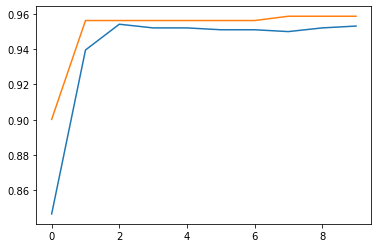

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])